In [1]:
# import random
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit
import numpy as np
# np.random.seed(11)
from qiskit import QuantumCircuit, transpile
import numpy as np
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, errors

In [2]:
def create_noise_model(f):
    noise_model = NoiseModel()

    # Add a bit-flip error on all single-qubit gates with a probability of 0.05
    bit_flip_error = errors.pauli_error([('X', f), ('I', 1-f)])
    noise_model.add_all_qubit_quantum_error(bit_flip_error, ['u1', 'u2', 'u3', 'rz', 'sx', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg'])

    # Add a phase-flip error on all single-qubit gates with a probability of 0.05
    phase_flip_error = errors.pauli_error([('Z', f), ('I', 1-f)])
    noise_model.add_all_qubit_quantum_error(phase_flip_error, ['u1', 'u2', 'u3', 'rz', 'sx', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg'])
    
    # Add a depolarizing error on two-qubit gates with a probability of 0.05
    depolarizing_error = errors.depolarizing_error(f, 2)
    noise_model.add_all_qubit_quantum_error(depolarizing_error, ['cx'])

    return noise_model

In [3]:
def simon_function(s: str):
    """
    Create a QuantumCircuit implementing a query gate for Simon problem obeying the promise for the hidden string `s`
    """
    # Our quantum circuit has 2n qubits for n = len(s)
    n = len(s)
    qc = QuantumCircuit(2 * n)

    # Define a random permutation of all n bit strings. This permutation will effectively hide the string s.
    pi = np.random.permutation(2**n)

    # Now we'll define a query gate explicitly. The idea is to first define a function g(x) = min{x,x ^ s}, which
    # is a simple function that satisfies the promise, and then we take f to be the composition of g and the random
    # permutation pi. This gives us a random function satisfying the promise for s.

    query_gate = np.zeros((4**n, 4**n))
    for x in range(2**n):
        for y in range(2**n):
            z = y ^ pi[min(x, x ^ int(s, 2))]
            query_gate[x + 2**n * z, x + 2**n * y] = 1
            # if x==y:
            #     query_gate[x,y]=1

    
    # display(query_gate)

    # Our circuit has just this one query gate
    qc.unitary(query_gate, range(2 * n))
    return qc

In [10]:
from qiskit_aer import AerSimulator
from qiskit import ClassicalRegister
from qiskit import transpile

def simon_measurements(problem: QuantumCircuit, k: int, noise_model):
    """
    Quantum part of Simon's algorithm. Given a `QuantumCircuit` that
    implements f, get `k` measurements to be post-processed later.
    """
    n = problem.num_qubits // 2

    qc = QuantumCircuit(2 * n, n)
    qc.h(range(n))
    # qc.x(n-1)  #bug
    qc.compose(problem, inplace=True)
    # qc.z(0)    #bug
    qc.h(range(n))
    # qc.x(0)    #bug
    qc.measure(range(n), range(n))

    result = AerSimulator(noise_model=noise_model).run(qc, shots=k, memory=True).result()
    # return result.get_memory()
    return result.get_counts()

In [5]:
from math import log2

def calculate_bias_entropy(output_map, unwanted_states):
    total_count = sum(output_map.values())

    bias = 0
    count = 0
    for key, val in output_map.items():
        if key in unwanted_states:
            bias += val / total_count
        count += 1

    entropy = 0
    for key, val in output_map.items():
        if (val == 0):
            continue
        else:
            p = val / total_count
            entropy = entropy - p * log2(p)

    return bias, entropy

In [6]:
def to_bin(number, num_bits):
    return format(number, f'0{num_bits}b')

In [7]:
def simons_non_ys(s):
    n = len(s)
    l=[]
    for i in range(0, pow(2,n)):
        y = to_bin(i, n)
        dot=0
        for p in range(n):
            dot+=int(y[p], 2) * int(s[p], 2)
        if dot%2 != 0:
            l.append(y)

    return l

In [12]:
def empty_dict(n):
    dict = {}
    keys = [to_bin(i,n) for i in range(pow(2,n))]
    dict = dict.fromkeys(keys, 0)
    return dict

In [ ]:
shots=100000
s='1101'
unwanted = simons_non_ys(s)

# Count Histogram

bias: 0, entropy: 2.999960267450228


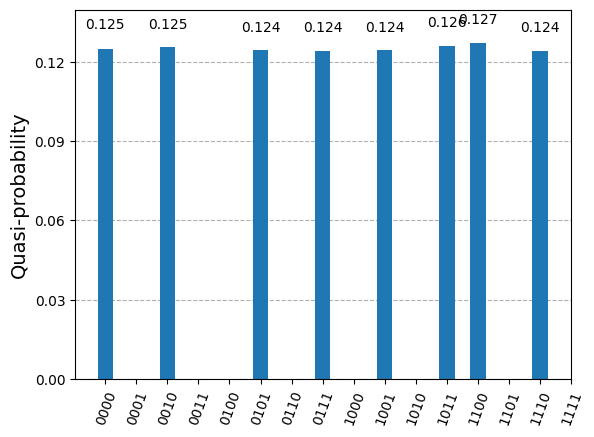

In [15]:
results = simon_measurements(simon_function(s),k=shots,noise_model=None)
dist = empty_dict(len(s))
for key, val in results.items():
    dist[key] = val/shots
    
arr = calculate_bias_entropy(results, unwanted)
print(f"bias: {arr[0]}, entropy: {arr[1]}")
plot_histogram(dist)

# Plot of Entropy vs Noise

In [ ]:
biases = []
entropies = []
noise_levels = [j/100.0 for j in range(0, 51)]
for i in noise_levels:
    noise = create_noise_model(i)
    results = simon_measurements(simon_function(s),k=shots,noise_model=noise)
    arr = calculate_bias_entropy(results, unwanted)
    biases.append(arr[0])
    entropies.append(arr[1])
# print(f"bias: {arr[0]}, entropy: {arr[1]}")
# plot_histogram(results)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(noise_levels, entropies, marker='o')  # marker='o' adds points for each x-y pair
plt.xlabel('noise_level')
plt.ylabel('entropy')
plt.title('Plot of Entropy vs Noise')
plt.grid(True)
plt.show()